In [1]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from IPython.display import Image
import imutils   

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.models import load_model
import keras
import tensorflow.keras as K

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import imutils   

In [2]:
#specify director
#specify directory
train_dir = 'content/Final_Dataset_Model2/train/'
test_dir = 'content/Final_Dataset_Model2/test'

In [3]:
classes = os.listdir('content/Final_Dataset_Model2/train')

In [4]:
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

In [11]:
files_path_dict = {}

for c in classes:
  files_path_dict[c] = list(map(lambda x: train_dir + c + '/' + x, os.listdir(train_dir + c)))

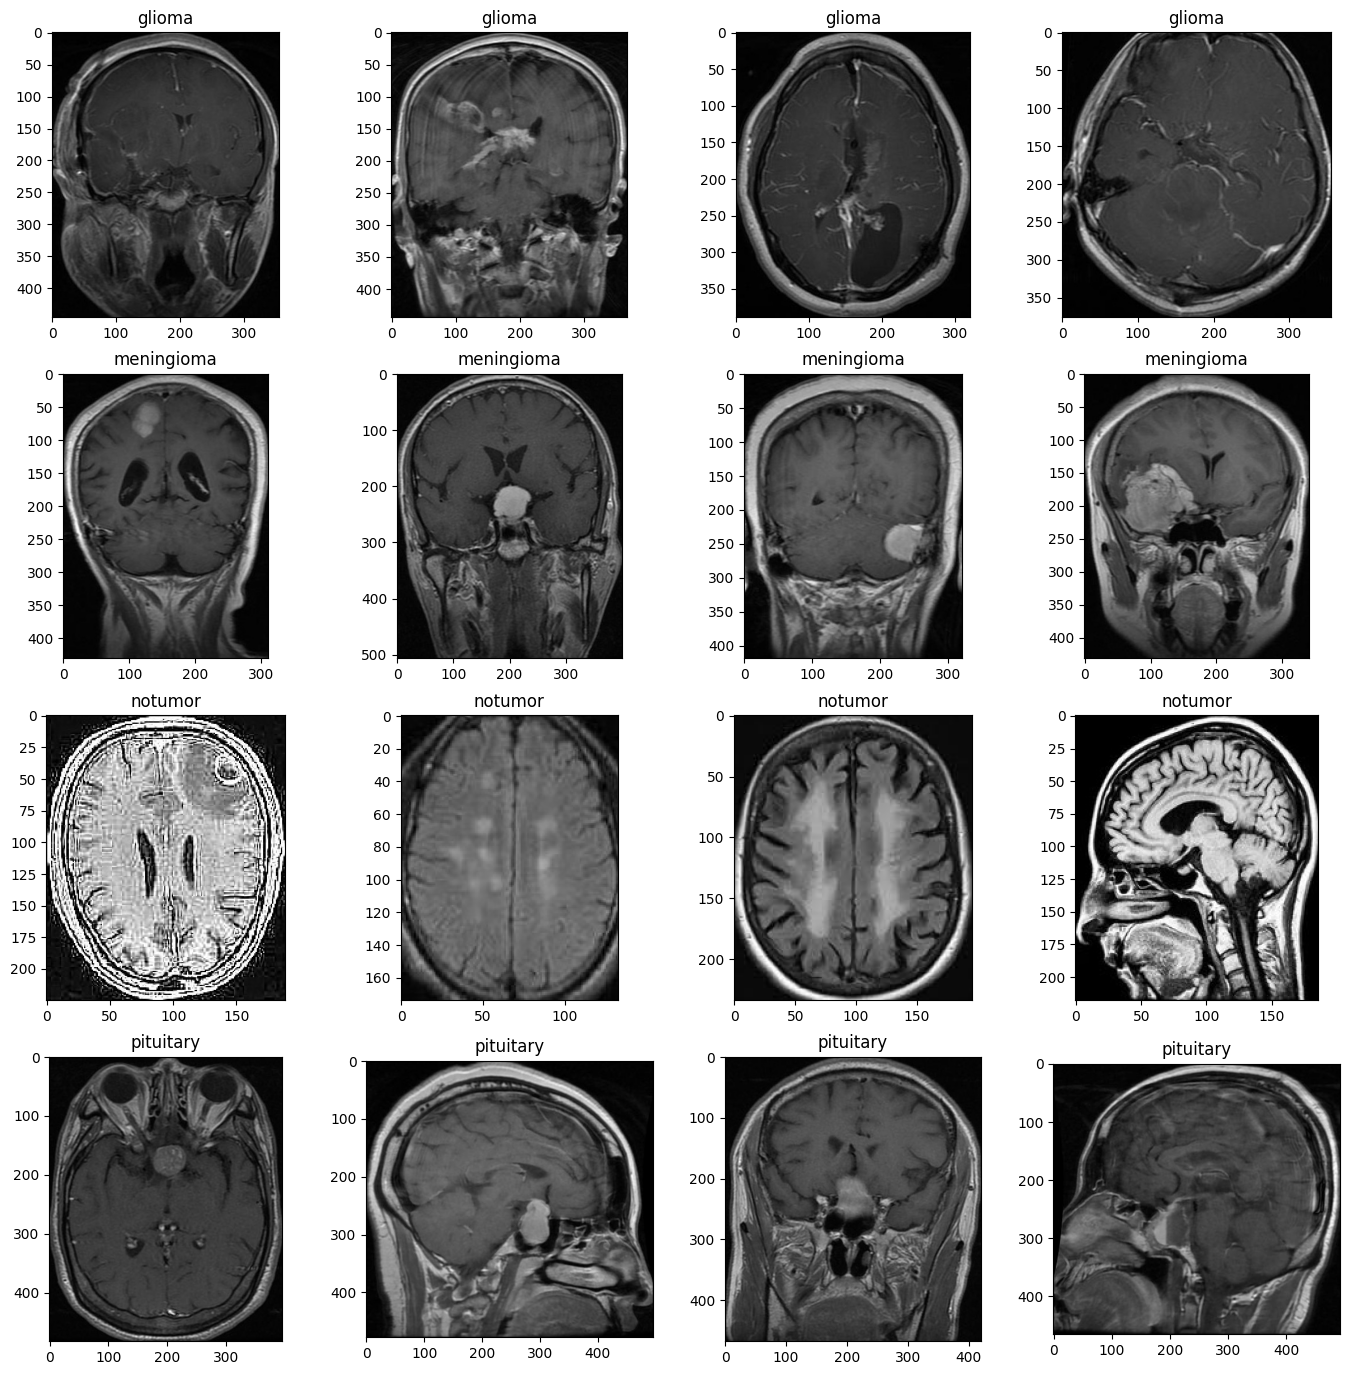

In [12]:
plt.figure(figsize = (17,17))
index = 0
for c in classes:
  random.shuffle(files_path_dict[c])
  path_list = files_path_dict[c][:5]

  for i in range(1, 5):
    index += 1
    plt.subplot(4, 4, index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)

In [4]:
#check the number of images in each class in the training dataset
No_images_per_class = []
Class_name = []

for i in os.listdir('content/Final_Dataset_Model2/train'):
  train_class = os.listdir(os.path.join('content/Final_Dataset_Model2/train', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in glioma = 1485 

Number of images in meningioma = 1486 

Number of images in notumor = 1861 

Number of images in pituitary = 1596 



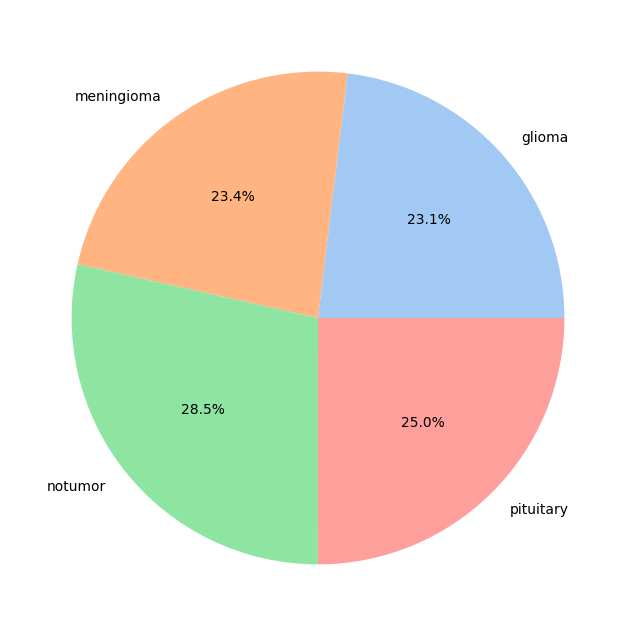

In [15]:

#visualize class distribution in train set
plt.figure(figsize=(8, 8))
colors = sns.color_palette('pastel')
plt.pie(No_images_per_class, 
        labels = Class_name, 
        autopct = '%1.1f%%',
        colors=colors)
plt.show()

In [20]:
def crop_image(image, plot=False):
    
    #convert to grayscale
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #blur
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    #apply binary threshhold
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]

    #apply erosion
    img_thresh = cv2.erode(img_thresh, None, iterations=2)

    #dilate images
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    #find shapes or the contour of images
    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #grab contours
    contours = imutils.grab_contours(contours)

    #find biggest contour
    c = max(contours, key=cv2.contourArea)

    #extract contour positions
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    #generate new image
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    #plot
    if plot:
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

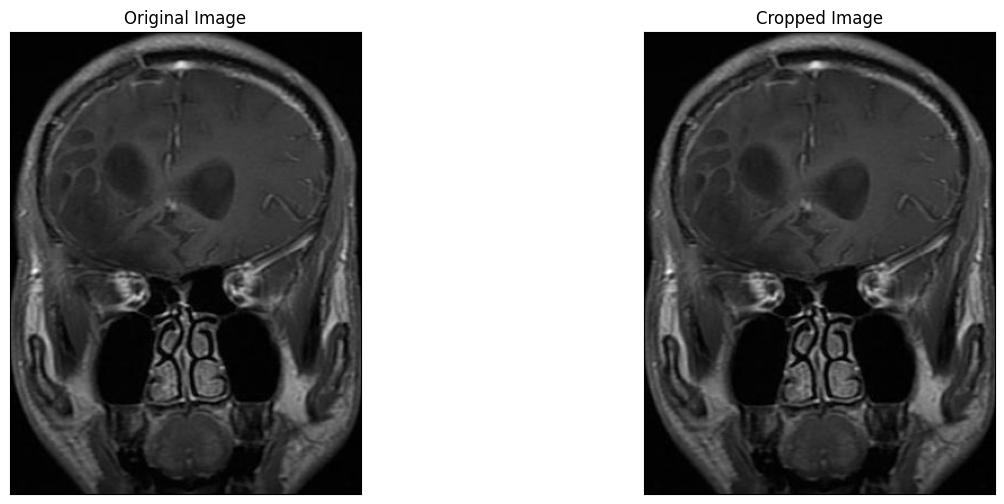

In [22]:
example_image = cv2.imread('content/Final_Dataset_Model2/test/glioma/glioma_4.jpg')
cropped_image = crop_image(example_image, plot=True)

In [18]:
#crop training images and save it to the directory we previously created
glioma = train_dir + 'glioma'
meningioma = train_dir + 'meningioma'
pituitary = train_dir + 'pituitary'
no_tumor = train_dir + 'notumor'

j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = 'content/Final_Dataset_Model2/train/glioma' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = 'content/Final_Dataset_Model2/train/meningioma' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1  

j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = 'content/Final_Dataset_Model2/train/notumor' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1  

j = 0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = 'content/Final_Dataset_Model2/train/pituitary' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1 

100%|██████████████████████████████████████████████████████████████████████████████| 1700/1700 [00:22<00:00, 74.92it/s]


In [39]:
#use Image Data Generator to perform this task
#train set
datagen = ImageDataGenerator(rotation_range=10,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2)

train_data = datagen.flow_from_directory('content/Final_Dataset_Model2/train',
                                         target_size=(240, 240),
                                         batch_size=32,
                                         class_mode='categorical',
                                         subset='training')

valid_data = datagen.flow_from_directory('content/Final_Dataset_Model2/train',
                                         target_size=(240, 240),
                                         batch_size=32,
                                         class_mode='categorical',
                                         subset='validation')

#test set
test_datagen = ImageDataGenerator()

test_data = datagen.flow_from_directory('content/Final_Dataset_Model2/test',
                                         target_size=(240, 240),
                                        class_mode='categorical',
                                        shuffle=False)
                                        

Found 5143 images belonging to 4 classes.
Found 1285 images belonging to 4 classes.
Found 1057 images belonging to 4 classes.


In [5]:
print(train_data.class_indices)
print(test_data.class_indices)

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


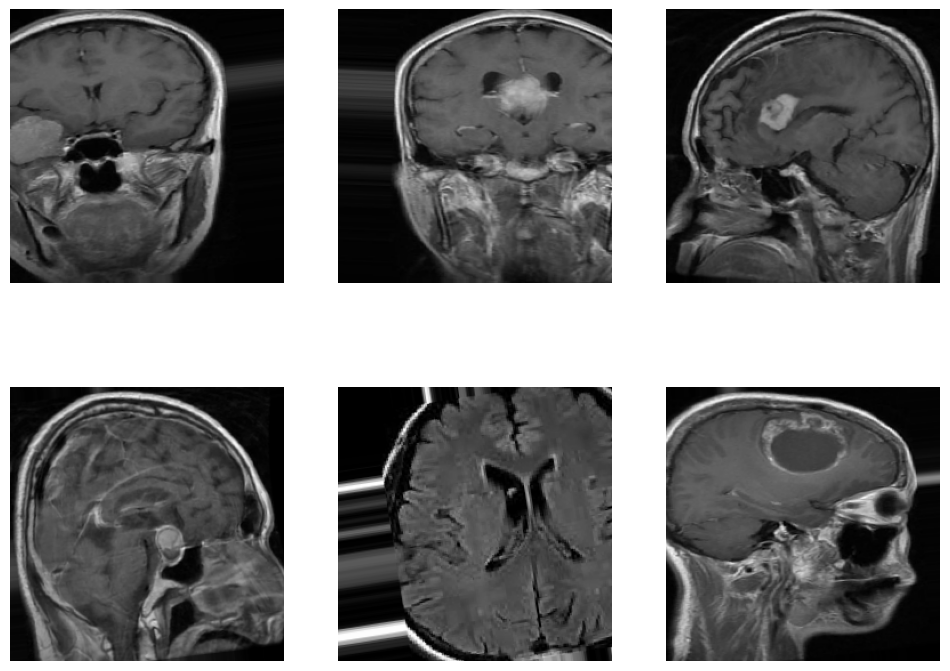

In [5]:

#view the augmented data
sample_x, sample_y = next(train_data)
plt.figure(figsize=(12, 9))
for i in range(6):
  plt.subplot(2, 3, i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)
plt.show()

In [5]:
#build the model
effnet = EfficientNetB1(weights='imagenet', 
                        include_top=False, 
                        input_shape=(240, 240, 3))

model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation='softmax')(model)
model = Model(inputs=effnet.input, 
              outputs=model)

#get summary()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 240, 240, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 240, 240, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 240, 240, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 240, 240, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 241, 241, 3)       │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 120, 120, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 120, 120, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 120, 120, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 120, 120, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 120, 120, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 120, 120, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 6,580,363 (25.10 MB)

 Trainable params: 6,518,308 (24.87 MB)

 Non-trainable params: 62,055 (242.41 KB)

In [3]:
#compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#define checkpoint
checkpoint = ModelCheckpoint('brain.keras', 
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='auto',
                             verbose=1)

#early stopping
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=3,
                          mode='auto',
                          verbose=1)

#reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.3, 
                              patience = 2, 
                              min_delta = 0.001,
                              mode='auto',
                              verbose=1)

In [5]:
model=load_model('brain.keras')

In [ ]:
## %%time

#train the model
history = model.fit(train_data,
                    epochs = 50,
                    validation_data=valid_data,
                    verbose=1,
                    callbacks=[checkpoint, earlystop, reduce_lr])

In [5]:
print('Train accuracy & loss:', model.evaluate(train_data))
print('\n')
print('Test accuracy & loss:', model.evaluate(test_data))

C:\Users\PRIYA\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


161/161 ━━━━━━━━━━━━━━━━━━━━ 430s 3s/step - accuracy: 0.9993 - loss: 0.0036
Train accuracy & loss: [0.004215449560433626, 0.999416708946228]


34/34 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.9940 - loss: 0.0204
Test accuracy & loss: [0.02514999359846115, 0.9924314022064209]


In [7]:
print('Test accuracy & loss:', model.evaluate(test_data))

C:\Users\PRIYA\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9958 - loss: 0.0193
Test accuracy & loss: [0.023697715252637863, 0.9943235516548157]


In [14]:

#define labels for testing
y_test = test_data.classes

#make prediction
yhat_test = np.argmax(model.predict(test_data), axis=1)

34/34 ━━━━━━━━━━━━━━━━━━━━ 34s 982ms/step


In [15]:
y_test
yhat_test

array([0, 0, 0, ..., 3, 3, 3], dtype=int64)

In [9]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [5]:
test_dir = 'content/Final_Dataset_Model2/test'  # Path to your test dataset

# Define class indices
class_indices = {
    'glioma': 0,
    'meningioma': 1,
    'notumor': 2,
    'pituitary': 3
}

# Initialize the actual_labels dictionary
actual_labels = {}

# Iterate through each class folder
for class_name, class_index in class_indices.items():
    class_folder = os.path.join(test_dir, class_name)  # Path to the specific class folder
    for filename in os.listdir(class_folder):  # List all files in the class folder
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Check for image file types
            # Add to the dictionary: filename -> class index
            path=os.path.join(class_folder,filename) 
            actual_labels[path] = class_index

# Print the actual_labels dictionary
print(actual_labels)

{'content/Final_Dataset_Model2/test\\glioma\\glioma_1004.jpg': 0, 'content/Final_Dataset_Model2/test\\glioma\\glioma_1016.jpg': 0, 'content/Final_Dataset_Model2/test\\glioma\\glioma_1023.jpg': 0, 'content/Final_Dataset_Model2/test\\glioma\\glioma_1029.jpg': 0, 'content/Final_Dataset_Model2/test\\glioma\\glioma_1030.jpg': 0, 'content/Final_Dataset_Model2/test\\glioma\\glioma_1035.jpg': 0, 'content/Final_Dataset_Model2/test\\glioma\\glioma_1044.jpg': 0, 'content/Final_Dataset_Model2/test\\glioma\\glioma_105.jpg': 0, 'content/Final_Dataset_Model2/test\\glioma\\glioma_1058.jpg': 0, 'content/Final_Dataset_Model2/test\\glioma\\glioma_1060.jpg': 0, 'content/Final_Dataset_Model2/test\\glioma\\glioma_1065.jpg': 0, 'content/Final_Dataset_Model2/test\\glioma\\glioma_1082.jpg': 0, 'content/Final_Dataset_Model2/test\\glioma\\glioma_1083.jpg': 0, 'content/Final_Dataset_Model2/test\\glioma\\glioma_1091.jpg': 0, 'content/Final_Dataset_Model2/test\\glioma\\glioma_1103.jpg': 0, 'content/Final_Dataset_Mo

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import os
from tabulate import tabulate

# Define the image dimensions and your model's class indices
 # Set to your model's input dimensions
class_indices = {0: 'Glioma', 1: 'Meningioma', 2: 'No Tumor', 3: 'Pituitary'}  # Adjust based on your model's output classes

# Function to predict the tumor type
def predict_tumor_type(img_path):
    img = image.load_img(img_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT), color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make predictions
    predictions = regular_model.predict(img_array)

    # Get the class with the highest probability
    predicted_class = np.argmax(predictions, axis=1)[0]
    return predicted_class

# Path to your test images and actual labels
test_dir = 'Final_Dataset/test'

wrong_predictions = []

# Iterate through the test images
for img_name, true_label in actual_labels.items():
    # Only predict if the image exists
    if os.path.exists(img_name):
        predicted_label = predict_tumor_type(img_name)

        # Check if the prediction is wrong
        if predicted_label != true_label:
            wrong_predictions.append((img_name, class_indices[predicted_label], class_indices[true_label]))

# Print wrong predictions as a table
if wrong_predictions:
    print("Wrong Predictions:",len(wrong_predictions),'/',len(actual_labels))
    print(tabulate(wrong_predictions, headers=["Image Name", "Predicted", "Actual"], tablefmt="grid"))
else:
    print("All predictions were correct!")


In [16]:
import os
from tabulate import tabulate

# Define the class indices for mapping predictions to class names
class_indices = {
    0: 'glioma',
    1: 'meningioma',
    2: 'notumor',
    3: 'pituitary'
}

# Reverse the class indices for easier lookup from class number to class name
rev_class_indices = {v: k for k, v in class_indices.items()}

# Function to find and print wrongly predicted images in tabular form
def find_wrong_predictions(yhat_test, y_test, test_dir, actual_labels):
    wrong_predictions = []
    image_files = list(actual_labels.keys())  # List of image file paths

    # Iterate over the predicted and actual labels
    for i, (predicted_label, actual_label) in enumerate(zip(yhat_test, y_test)):
        # Compare actual and predicted labels
        if predicted_label != actual_label:
            # Get the actual and predicted class names
            actual_class_name = class_indices[actual_label]
            predicted_class_name = class_indices[predicted_label]

            # Get the corresponding image file path and extract the image name
            img_path = image_files[i]
            img_name = os.path.basename(img_path)

            # Append the details of the wrong prediction
            wrong_predictions.append([img_name, actual_class_name, predicted_class_name])

    # Use tabulate to print the wrong predictions in tabular format
    headers = ["Image Name", "Actual Label", "Predicted Label"]
    print(tabulate(wrong_predictions, headers=headers, tablefmt="grid"))
    
    return wrong_predictions

# Example: Assuming you have `yhat_test` and `y_test` already computed
wrong_predictions = find_wrong_predictions(yhat_test, y_test, 'content/Final_Dataset_Model2/test', actual_labels)


+---------------------+----------------+-------------------+
| Image Name          | Actual Label   | Predicted Label   |
+=====================+================+===================+
| meningioma_1006.jpg | meningioma     | glioma            |
+---------------------+----------------+-------------------+
| meningioma_1446.jpg | meningioma     | pituitary         |
+---------------------+----------------+-------------------+
| meningioma_211.jpg  | meningioma     | glioma            |
+---------------------+----------------+-------------------+
| notumor_356.jpg     | notumor        | pituitary         |
+---------------------+----------------+-------------------+
| pituitary_1518.jpg  | pituitary      | meningioma        |
+---------------------+----------------+-------------------+
| pituitary_81.jpg    | pituitary      | meningioma        |
+---------------------+----------------+-------------------+


In [17]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

[[244   0   0   0]
 [  2 245   0   1]
 [  0   0 299   1]
 [  0   2   0 263]]


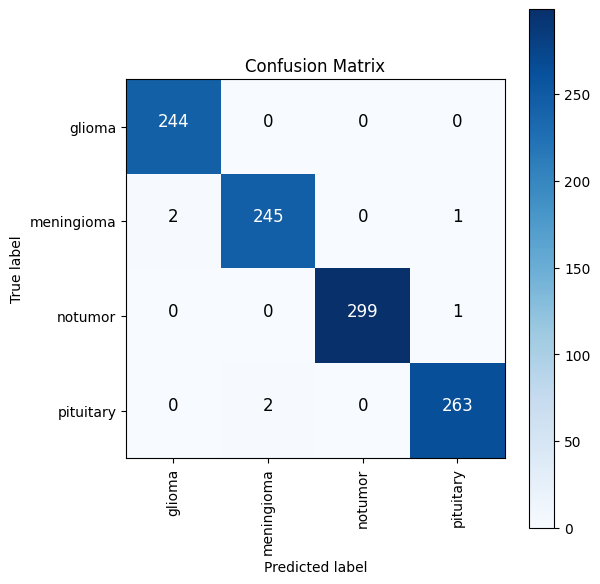

In [18]:

#get confusion matrix
cm = confusion_matrix(y_test, yhat_test)
print(cm)

#plot
plot_confusion_matrix(cm, classes, normalize=False)

In [12]:
#get classification report
print(classification_report(y_test, yhat_test))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       244
           1       0.99      0.99      0.99       248
           2       1.00      1.00      1.00       300
           3       1.00      0.99      0.99       265

    accuracy                           0.99      1057
   macro avg       0.99      0.99      0.99      1057
weighted avg       0.99      0.99      0.99      1057



In [18]:
import numpy as np
from tensorflow.keras.preprocessing import image
import os
from tabulate import tabulate

# Define the image dimensions and your model's class indices
IMAGE_WIDTH, IMAGE_HEIGHT = 240, 240  # Set to your model's input dimensions
class_indices = {0: 'Glioma', 1: 'Meningioma', 2: 'No Tumor', 3: 'Pituitary'}  # Adjust based on your model's output classes

# Function to predict the tumor type
def predict_tumor_type(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (240, 240))
    img = img_to_array(img)  # Convert to array
    img = np.expand_dims(img, axis=0) 

    # Make predictions
    predictions = model.predict(img)

    # Get the class with the highest probability
    predicted_class = np.argmax(predictions, axis=1)[0]
    return predicted_class

# Path to your test images and actual labels
test_dir = 'content/Final_Dataset_Model2/test/'

wrong_predictions = []

# Iterate through the test images
for img_name, true_label in actual_labels.items():
    # Only predict if the image exists
    if os.path.exists(img_name):
        predicted_label = predict_tumor_type(img_name)

        # Check if the prediction is wrong
        if predicted_label != true_label:
            wrong_predictions.append((img_name, class_indices[predicted_label], class_indices[true_label]))

# Print wrong predictions as a table
if wrong_predictions:
    print("Wrong Predictions:",len(wrong_predictions),'/',len(actual_labels))
    print(tabulate(wrong_predictions, headers=["Image Name", "Predicted", "Actual"], tablefmt="grid"))
else:
    print("All predictions were correct!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━

In [13]:

last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D))
last_conv_layer.name

'top_conv'

In [14]:
def VizGradCAM(model, image, interpolant=0.5, plot_results=True):

    """VizGradCAM - Displays GradCAM based on Keras / TensorFlow models
    using the gradients from the last convolutional layer. This function
    should work with all Keras Application listed here:
    https://keras.io/api/applications/
    Parameters:
    model (keras.model): Compiled Model with Weights Loaded
    image: Image to Perform Inference On
    plot_results (boolean): True - Function Plots using PLT
                            False - Returns Heatmap Array
    Returns:
    Heatmap Array?
    """
    #sanity check
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"

    #STEP 1: Preprocesss image and make prediction using our model
    #input image
    original_img = np.asarray(image, dtype = np.float32)
    #expamd dimension and get batch size
    img = np.expand_dims(original_img, axis=0)
    #predict
    prediction = model.predict(img)
    #prediction index
    prediction_idx = np.argmax(prediction)

    #STEP 2: Create new model
    #specify last convolutional layer
    last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D))
    target_layer = model.get_layer(last_conv_layer.name)

    #compute gradient of top predicted class
    with tf.GradientTape() as tape:
        #create a model with original model inputs and the last conv_layer as the output
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        #pass the image through the base model and get the feature map  
        conv2d_out, prediction = gradient_model(img)
        #prediction loss
        loss = prediction[:, prediction_idx]

    #gradient() computes the gradient using operations recorded in context of this tape
    gradients = tape.gradient(loss, conv2d_out)

    #obtain the output from shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]

    #obtain depthwise mean
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))


    #create a 7x7 map for aggregation
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)
    #multiply weight for every layer
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]
    #resize to image size
    activation_map = cv2.resize(activation_map.numpy(), 
                                (original_img.shape[1], 
                                 original_img.shape[0]))
    #ensure no negative number
    activation_map = np.maximum(activation_map, 0)
    #convert class activation map to 0 - 255
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    #rescale and convert the type to int
    activation_map = np.uint8(255 * activation_map)


    #convert to heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    #superimpose heatmap onto image
    original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    cvt_heatmap = img_to_array(cvt_heatmap)

    #enlarge plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results == True:
        plt.imshow(np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant)))
    else:
        return cvt_heatmap

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


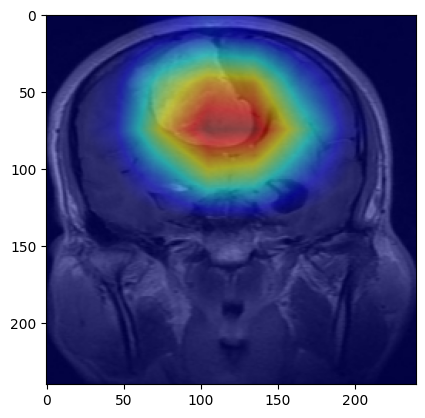

In [31]:
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model

def VizGradCAM(model, image, interpolant=0.5, plot_results=True):
    """ VizGradCAM - Displays GradCAM based on Keras / TensorFlow models
        using the gradients from the last convolutional layer. 
    """
    # Ensure interpolant is within the valid range
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"

    # STEP 1: Preprocess image and make prediction using the model
    original_img = np.asarray(image, dtype=np.float32)
    img = np.expand_dims(original_img, axis=0)
    prediction = model.predict(img)
    prediction_idx = np.argmax(prediction)

    # STEP 2: Identify the last convolutional layer in the model
    last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, tf.keras.layers.Conv2D))
    target_layer = model.get_layer(last_conv_layer.name)

    with tf.GradientTape() as tape:
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        conv2d_out, prediction = gradient_model(img)
        loss = prediction[:, prediction_idx]

    gradients = tape.gradient(loss, conv2d_out)
    output = conv2d_out[0]

    # Depthwise mean to get the weights for the heatmap
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)
    
    # Create activation map
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]
    
    activation_map = cv2.resize(activation_map.numpy(), (original_img.shape[1], original_img.shape[0]))
    activation_map = np.maximum(activation_map, 0)
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    activation_map = np.uint8(255 * activation_map)

    # Convert to heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    # Superimpose heatmap on the original image
    original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    cvt_heatmap = img_to_array(cvt_heatmap)
    # Save the visualization image
    plt.rcParams["figure.dpi"] = 100

    if plot_results:
        plt.imshow(np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant)))
    else:
        return cvt_heatmap

# Load image and check if it's loaded correctly
image_path = "content/Final_Dataset_Model2/test/meningioma/meningioma_132.jpg"
test_img = cv2.imread(image_path)

if test_img is None:
    print(f"Error: Unable to read image at path {image_path}")
else:
    # Resize the image to the expected input shape (240, 240)
    test_img = cv2.resize(test_img, (240, 240))
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    VizGradCAM(model, img_to_array(test_img), plot_results=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


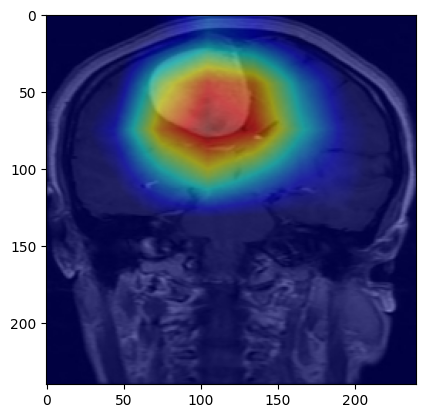

In [33]:
image_path = "content/Final_Dataset_Model2/test/meningioma/meningioma_162.jpg"
test_img = cv2.imread(image_path)
test_img = cv2.resize(test_img, (240, 240))
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
VizGradCAM(model, img_to_array(test_img), plot_results=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


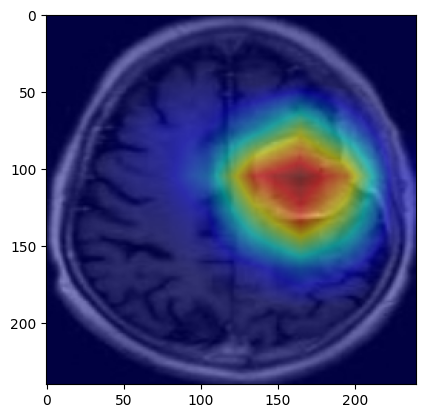

In [34]:
image_path = "content/Final_Dataset_Model2/test/meningioma/meningioma_300.jpg"
test_img = cv2.imread(image_path)
test_img = cv2.resize(test_img, (240, 240))
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
VizGradCAM(model, img_to_array(test_img), plot_results=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


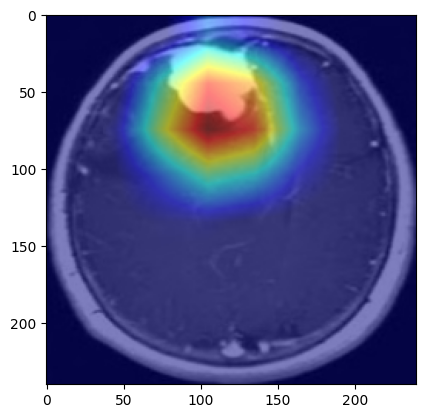

In [35]:
image_path = "content/Final_Dataset_Model2/test/meningioma/meningioma_223.jpg"
test_img = cv2.imread(image_path)
test_img = cv2.resize(test_img, (240, 240))
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
VizGradCAM(model, img_to_array(test_img), plot_results=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


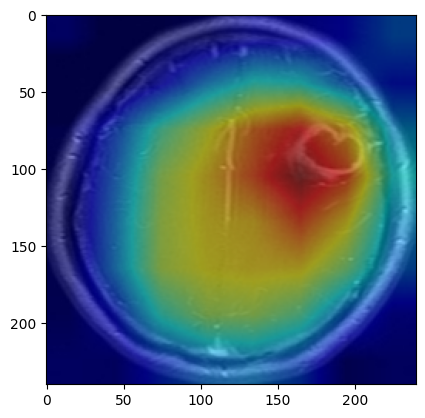

In [36]:
image_path = "content/Final_Dataset_Model2/test/glioma/glioma_60.jpg"
test_img = cv2.imread(image_path)
test_img = cv2.resize(test_img, (240, 240))
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
VizGradCAM(model, img_to_array(test_img), plot_results=True)

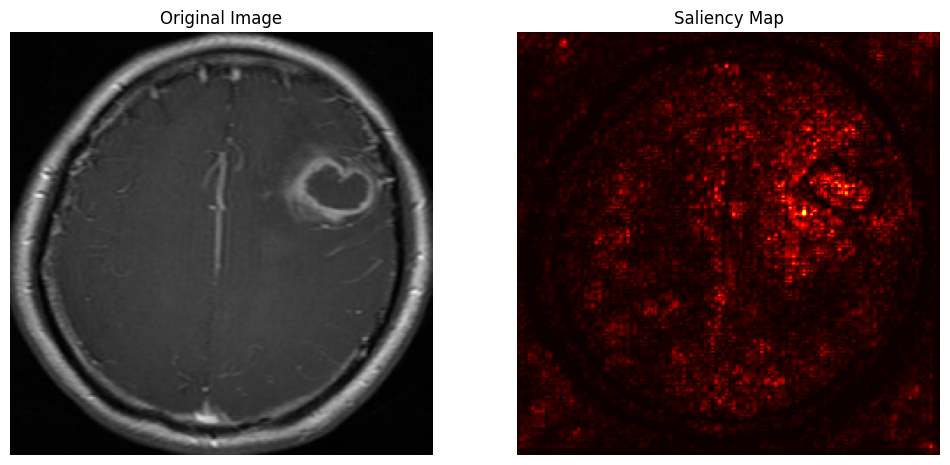

In [21]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array

def compute_saliency_map(model, image):
    """ Computes the Saliency Map for a given input image using the specified model. """
    # Convert the image to a tensor
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    image_tensor = tf.expand_dims(image_tensor, axis=0)  # Add batch dimension
    
    with tf.GradientTape() as tape:
        # Watch the input image
        tape.watch(image_tensor)
        # Get model prediction
        prediction = model(image_tensor)
        predicted_class = tf.argmax(prediction[0]).numpy()  # Get the class index

        # Calculate the gradient of the predicted class with respect to the input image
        grads = tape.gradient(prediction[0][predicted_class], image_tensor)

    # Get the saliency map by taking the maximum absolute gradient across the color channels
    saliency = tf.reduce_max(tf.abs(grads), axis=-1).numpy()[0]  # Get the saliency for the first (and only) image

    return saliency

def plot_saliency_map(original_image, saliency_map):
    """ Plots the original image and its corresponding saliency map. """
    plt.figure(figsize=(12, 6))
    
    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image.astype(np.uint8))
    plt.axis('off')
    plt.title('Original Image')

    # Plot saliency map
    plt.subplot(1, 2, 2)
    plt.imshow(saliency_map, cmap='hot')
    plt.axis('off')
    plt.title('Saliency Map')

    plt.show()

# Load image and preprocess
image_path = "content/Final_Dataset_Model2/test/glioma/glioma_60.jpg"
test_img = cv2.imread(image_path)

if test_img is None:
    print(f"Error: Unable to read image at path {image_path}")
else:
    # Resize and preprocess the image
    test_img = cv2.resize(test_img, (240, 240))
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Compute and plot the saliency map
    saliency_map = compute_saliency_map(model, img_to_array(test_img))
    plot_saliency_map(test_img, saliency_map)


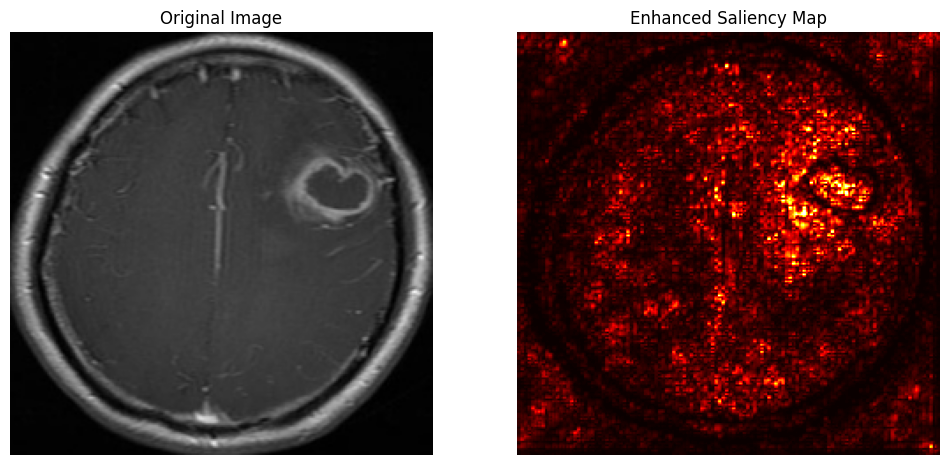

In [23]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array

def compute_saliency_map(model, image):
    """ Computes the Saliency Map for a given input image using the specified model. """
    # Convert the image to a tensor
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    image_tensor = tf.expand_dims(image_tensor, axis=0)  # Add batch dimension
    
    with tf.GradientTape() as tape:
        # Watch the input image
        tape.watch(image_tensor)
        # Get model prediction
        prediction = model(image_tensor)
        predicted_class = tf.argmax(prediction[0]).numpy()  # Get the class index

        # Calculate the gradient of the predicted class with respect to the input image
        grads = tape.gradient(prediction[0][predicted_class], image_tensor)

    # Get the saliency map by taking the maximum absolute gradient across the color channels
    saliency = tf.reduce_max(tf.abs(grads), axis=-1).numpy()[0]  # Get the saliency for the first (and only) image

    # Normalize the saliency map
    saliency = (saliency - np.min(saliency)) / (np.max(saliency) - np.min(saliency))
    
    # Scale the saliency map to enhance visibility
    saliency = np.clip(saliency * 2, 0, 1)  # Amplify bright areas
    saliency = np.uint8(255 * saliency)  # Convert to uint8 format

    return saliency

def plot_saliency_map(original_image, saliency_map):
    """ Plots the original image and its corresponding saliency map. """
    plt.figure(figsize=(12, 6))
    
    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image.astype(np.uint8))
    plt.axis('off')
    plt.title('Original Image')

    # Plot saliency map with bright areas emphasized
    plt.subplot(1, 2, 2)
    plt.imshow(saliency_map, cmap='hot')
    plt.axis('off')
    plt.title('Enhanced Saliency Map')

    plt.show()

# Load image and preprocess
image_path = "content/Final_Dataset_Model2/test/glioma/glioma_60.jpg"
test_img = cv2.imread(image_path)

if test_img is None:
    print(f"Error: Unable to read image at path {image_path}")
else:
    # Resize and preprocess the image
    test_img = cv2.resize(test_img, (240, 240))
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Compute and plot the enhanced saliency map
    saliency_map = compute_saliency_map(model, img_to_array(test_img))
    plot_saliency_map(test_img, saliency_map)


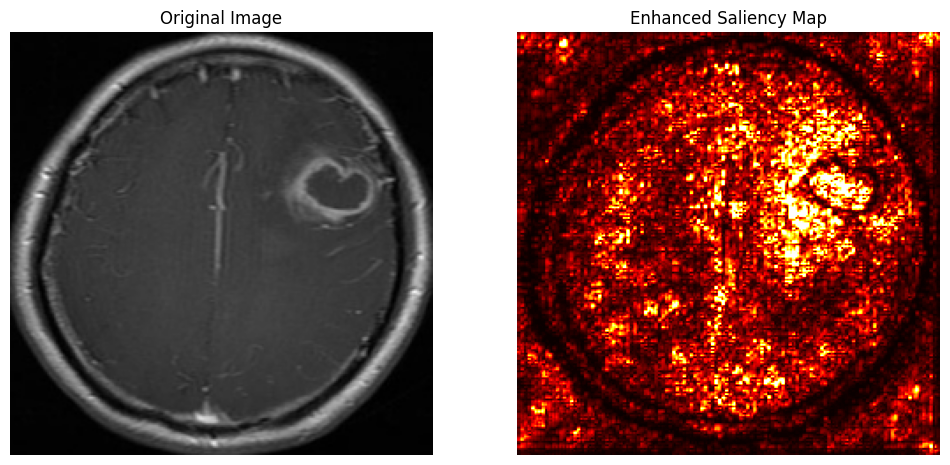

In [24]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array

def compute_saliency_map(model, image):
    """ Computes the Saliency Map for a given input image using the specified model. """
    # Convert the image to a tensor
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    image_tensor = tf.expand_dims(image_tensor, axis=0)  # Add batch dimension
    
    with tf.GradientTape() as tape:
        # Watch the input image
        tape.watch(image_tensor)
        # Get model prediction
        prediction = model(image_tensor)
        predicted_class = tf.argmax(prediction[0]).numpy()  # Get the class index

        # Calculate the gradient of the predicted class with respect to the input image
        grads = tape.gradient(prediction[0][predicted_class], image_tensor)

    # Get the saliency map by taking the maximum absolute gradient across the color channels
    saliency = tf.reduce_max(tf.abs(grads), axis=-1).numpy()[0]  # Get the saliency for the first (and only) image

    # Normalize the saliency map
    saliency = (saliency - np.min(saliency)) / (np.max(saliency) - np.min(saliency))
    
    # Scale the saliency map to enhance visibility (increase the factor for more brightness)
    saliency = np.clip(saliency * 5, 0, 1)  # Amplify bright areas even more
    saliency = np.uint8(255 * saliency)  # Convert to uint8 format

    return saliency

def plot_saliency_map(original_image, saliency_map):
    """ Plots the original image and its corresponding saliency map. """
    plt.figure(figsize=(12, 6))
    
    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image.astype(np.uint8))
    plt.axis('off')
    plt.title('Original Image')

    # Plot saliency map with bright areas emphasized
    plt.subplot(1, 2, 2)
    plt.imshow(saliency_map, cmap='hot')
    plt.axis('off')
    plt.title('Enhanced Saliency Map')

    plt.show()

# Load image and preprocess
image_path = "content/Final_Dataset_Model2/test/glioma/glioma_60.jpg"
test_img = cv2.imread(image_path)

if test_img is None:
    print(f"Error: Unable to read image at path {image_path}")
else:
    # Resize and preprocess the image
    test_img = cv2.resize(test_img, (240, 240))
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Compute and plot the enhanced saliency map
    saliency_map = compute_saliency_map(model, img_to_array(test_img))
    plot_saliency_map(test_img, saliency_map)


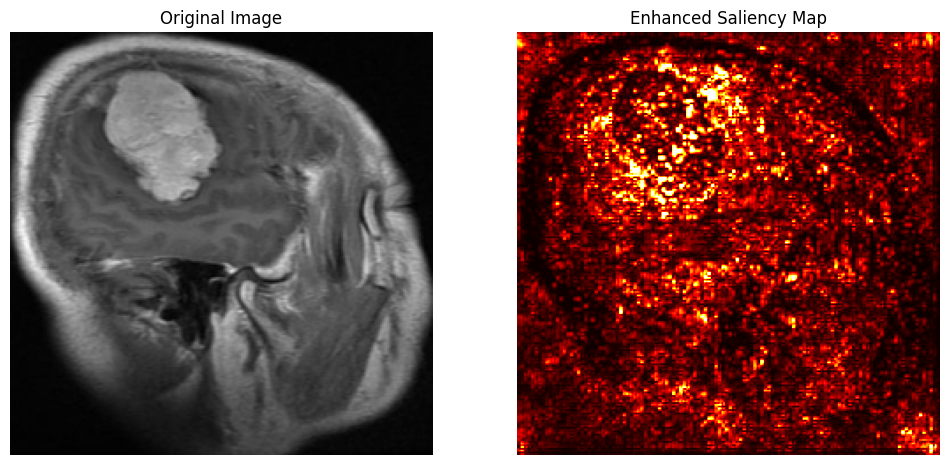

In [27]:
image_path = "content/Final_Dataset_Model2/test/meningioma/meningioma_812.jpg"
test_img = cv2.imread(image_path)

if test_img is None:
    print(f"Error: Unable to read image at path {image_path}")
else:
    # Resize and preprocess the image
    test_img = cv2.resize(test_img, (240, 240))
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Compute and plot the enhanced saliency map
    saliency_map = compute_saliency_map(model, img_to_array(test_img))
    plot_saliency_map(test_img, saliency_map)

In [ ]:
import numpy as np
import os
from tensorflow.keras.preprocessing import image
from tabulate import tabulate

# Define the image dimensions and your model's class indices
IMAGE_WIDTH, IMAGE_HEIGHT = 240, 240  # Set to your model's input dimensions
class_indices = {0: 'Glioma', 1: 'Meningioma', 2: 'No Tumor', 3: 'Pituitary'}  # Adjust based on your model's output classes

# Function to predict the tumor type
def predict_tumor_type(img_path, model):
    img = image.load_img(img_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make predictions
    predictions = model.predict(img_array)

    # Get the class with the highest probability
    predicted_class = np.argmax(predictions, axis=1)[0]
    return predicted_class


test_dir = 'content/Final_Dataset_Model2/test/'
wrong_predictions = []

# Iterate through the test images
for img_name, true_label in actual_labels.items():
    # Only predict if the image exists
    if os.path.exists(img_name):
        predicted_label = predict_tumor_type(img_name, model)

        # Check if the prediction is wrong
        if predicted_label != true_label:
            wrong_predictions.append((img_name, class_indices[predicted_label], class_indices[true_label]))

# Print wrong predictions as a table
if wrong_predictions:
    print(f"Wrong Predictions: {len(wrong_predictions)} / {len(actual_labels)}")
    print(tabulate(wrong_predictions, headers=["Image Name", "Predicted", "Actual"], tablefmt="grid"))
else:
    print("All predictions were correct!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━

In [35]:
df_yhat_test = pd.DataFrame(yhat_test, columns=['Predicted_Class'])

# Print the DataFrame
print(df_yhat_test)

      Predicted_Class
0                   0
1                   0
2                   0
3                   0
4                   0
...               ...
1052                3
1053                3
1054                3
1055                3
1056                3

[1057 rows x 1 columns]


In [49]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array

# Define the directory containing the test images
test_dir = "content/Final_Dataset_Model2/test/"

# Define class labels
class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# Function to predict tumor types and return results as a DataFrame
def predict_tumor_types(model, test_dir):
    results = []

    # Loop through each subfolder in the test directory
    for tumor_type in os.listdir(test_dir):
        tumor_folder = os.path.join(test_dir, tumor_type)
        
        # Check if it's a directory
        if os.path.isdir(tumor_folder):
            # Loop through each image in the tumor type folder
            for filename in os.listdir(tumor_folder):
                if filename.endswith('.jpg') or filename.endswith('.png'):  # Check for image files
                    image_path = os.path.join(tumor_folder, filename)
                    
                    # Load and preprocess the image
                    img = cv2.resize(img, (240, 240))
                    img = img_to_array(img)  # Convert to array
                    img = np.expand_dims(img, axis=0) 
                    
                    # Make prediction
                    probabilities = model.predict(img)[0]  # Get probabilities for all classes
                    predicted_class_index = np.argmax(probabilities)  # Get the predicted class index
                    
                    # Prepare result
                    result = {
                        'Image_Name': filename,
                        'Predicted_Class': class_labels[predicted_class_index],
                        'Probabilities': {label: prob for label, prob in zip(class_labels, probabilities)}
                    }
                    results.append(result)

    # Create a DataFrame from the results
    df_results = pd.DataFrame(results)
    return df_results

# Call the function and print the DataFrame
df_predictions = predict_tumor_types(model, test_dir)
print(df_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━

In [15]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

def predict_tumor(image_path, model):
    
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Error: Unable to read image at path {image_path}")
    
    # Resize the image to the expected input shape (240, 240)
    img = cv2.resize(img, (240, 240))
    img = img_to_array(img)  # Convert to array
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Predict using the model
    probabilities = model.predict(img)[0]  # Get probabilities for all classes
    predicted_class_index = np.argmax(probabilities)  # Get index of predicted class

    # Define class labels (update as per your classes)
    class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']  # Adjust this as necessary

    # Prepare the result
    result = {
        'predicted_class': class_labels[predicted_class_index],
        'probabilities': {label: prob for label, prob in zip(class_labels, probabilities)}
    }

    return result

# Example usage
image_path = "content/Final_Dataset_Model2/test/glioma/glioma_4.jpg"
result = predict_tumor(image_path, model)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
{'predicted_class': 'Glioma', 'probabilities': {'Glioma': 0.9999902, 'Meningioma': 6.654655e-06, 'No Tumor': 2.2131967e-06, 'Pituitary': 9.0175877e-07}}


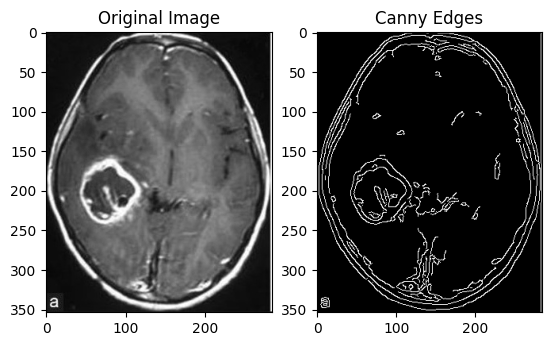

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the MRI image
image = cv2.imread('content/Final_Dataset_Model2/test/meningioma/meningioma_211.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply Canny edge detection
edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

# Display the original image and edges
plt.subplot(121), plt.imshow(gray, cmap='gray'), plt.title('Original Image')
plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title('Canny Edges')
plt.show()


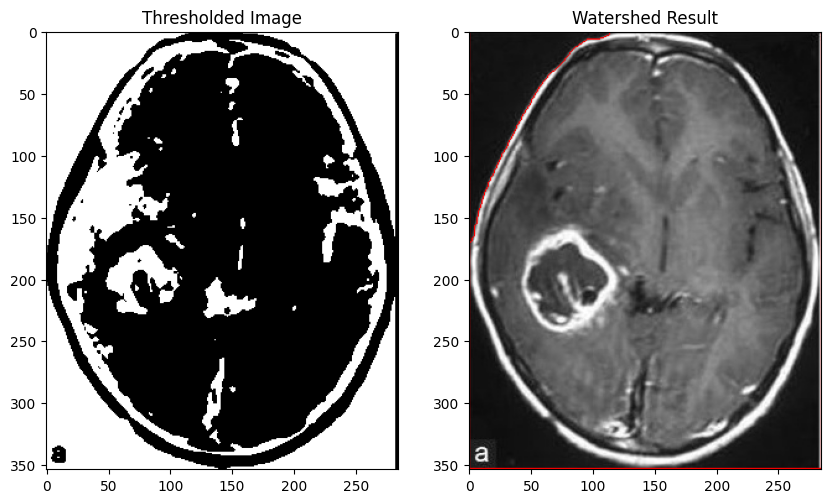

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the MRI image
image = cv2.imread('content/Final_Dataset_Model2/test/meningioma/meningioma_211.jpg')

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply thresholding to get binary image
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Noise removal using Morphological opening
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background area (dilate the image)
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Distance transform to calculate the sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Finding unknown region (subtract sure foreground from sure background)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
_, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that the sure background is not 0
markers = markers + 1

# Mark the region of unknown with zero
markers[unknown == 255] = 0

# Apply watershed algorithm
markers = cv2.watershed(image, markers)

# Mark the boundaries
image[markers == -1] = [255, 0, 0]

# Display the result
plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(thresh, cmap='gray'), plt.title('Thresholded Image')
plt.subplot(122), plt.imshow(image), plt.title('Watershed Result')
plt.show()


In [3]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

def predict_tumor(image_path, model, segmentation_model):
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Error: Unable to read image at path {image_path}")
    
    # Resize the image to the expected input shape for classification (240, 240)
    img_classification = cv2.resize(img, (240, 240))
    img_classification = img_to_array(img_classification)  # Convert to array
    img_classification = np.expand_dims(img_classification, axis=0)  # Add batch dimension

    # Predict using the classification model
    probabilities = model.predict(img_classification)[0]  # Get probabilities for all classes
    predicted_class_index = np.argmax(probabilities)  # Get index of predicted class

    # Define class labels (update as per your classes)
    class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']  # Adjust this as necessary

    # Prepare the classification result
    classification_result = {
        'predicted_class': class_labels[predicted_class_index],
        'probabilities': {label: prob for label, prob in zip(class_labels, probabilities)}
    }

    # Resize image for segmentation model
    img_segmentation = cv2.resize(img, (256, 256))  # Adjust input size for segmentation model
    img_segmentation = img_to_array(img_segmentation)
    img_segmentation = np.expand_dims(img_segmentation, axis=0)  # Add batch dimension

    # Predict the segmentation mask using the segmentation model
    predicted_mask = segmentation_model.predict(img_segmentation)[0]

    # Return both classification and segmentation results
    return classification_result, predicted_mask

# Example usage
image_path = "content/Final_Dataset_Model2/test/glioma/glioma_4.jpg"
classification_result, predicted_mask = predict_tumor(image_path, model, segmentation_model)

# Print classification results
print(classification_result)

# Visualize the predicted mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Predicted Mask")
plt.imshow(predicted_mask, cmap='gray')
plt.axis('off')

plt.show()


NameError: name 'segmentation_model' is not defined